In [1]:
import numpy as np
import math
from functools import reduce
import time
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)
from pathlib import Path
import nidaqmx

def lcm(a, b):
    """Calculate the least common multiple of two numbers."""
    return abs(a * b) // math.gcd(a, b)


def lcm_of_list(numbers):
    """Find the LCM of a list of numbers."""
    return reduce(lcm, numbers)

def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])

# some constants
Hz = 1e-9 # GHz
kHz = 1e-6 # GHz
MHz = 1e-3 # GHz
pi = np.pi

In [ ]:
# from logmodule import setup_logging


In [ ]:
# setup_logging()
# logger = logging.getLogger(__name__)


In [4]:
import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
from nidaqmx.stream_readers import AnalogSingleChannelReader

from hardware import config as hcf
from hardware.hardwaremanager import HardwareManager
from hardware.pulser.pulser import (
    OutputState,
    TriggerStart,
    TriggerRearm,
    HIGH,
    LOW,
    INF,
    REPEAT_INFINITELY
)
timebase = lcm_of_list(
    [hcf.VDISYN_timebase, hcf.SIDIG_timebase, hcf.PS_timebase, hcf.RSRF_timebase]
)

hw = HardwareManager()
# adds synthesizer, laser, and pulse generator 
hw.add_default_hardware()


2025-06-27 17:34:50 WARNING registry MainThread: Redefining 'S' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2025-06-27 17:34:50 WARNING registry MainThread: Redefining '‰' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2025-06-27 17:34:50 WARNING registry MainThread: Redefining 'permille' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2025-06-27 17:34:50 WARNING registry MainThread: Redefining 'Frac' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2025-06-27 17:34:50 WARNING registry MainThread: Redefining 'Fracs' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2025-06-27 17:34:50 INFO hardwaremanager MainThread: Added 'camera' for Thorlabs Camera with address <hardware.camera.thorlabs.CameraController object at 0x00000140DD5D1B70>
2025-06-27 17:34:50 INFO hardwaremanager MainThread: Added 'pg' for Pulse Streamer with address <hardware.pulser.pulser.PulseGenerator object at 0x00000140DD5D0A90>


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


2025-06-27 17:34:50 INFO hardwaremanager MainThread: Added 'whitelight' for WhiteLight on channel /Dev1/ao0 with address <hardware.camera.light.WhiteLight object at 0x00000140DD5D0250>
2025-06-27 17:34:50 INFO mwsource ThreadPoolExecutor-0_0: VDISource initialized and connections are open.
2025-06-27 17:34:50 INFO hardwaremanager MainThread: Added 'vdi' for VDI Source with address <hardware.mw.mwsource.VDISource object at 0x00000140DD597B80>
2025-06-27 17:34:51 INFO hardwaremanager MainThread: Added 'pwr' for Mini-Circuits Power Meter with address <hardware.mw.detector.pwrcontrol.MWPowerMeter object at 0x00000140DD597F10>
2025-06-27 17:34:51 INFO sidig ThreadPoolExecutor-0_4: Successfully connected to the digitizer
2025-06-27 17:34:51 INFO hardwaremanager MainThread: Added 'dig' for SI Digitizer with address <hardware.daq.sidig.FIFO_DataAcquisition object at 0x00000140DD5D16C0>
2025-06-27 17:34:51 INFO hardwaremanager MainThread: Added 'laser' for Laser Control with address <hardware.l

In [5]:
# pulse streamer pulse sequence 

def sequence_mw_phase_calibration(
    init_nslaser: int,
    init_isc: int,
    init_wait: int,
    init_repeat: int,
    read_wait: int,
    read_laser: int,
    mw_dur: int,
):
    seq_exp = []

    sub_init = [(["laser"], init_nslaser), ([], init_isc)] * init_repeat + [
        ([], init_wait)
    ]

    sub_evo_MWA = [(["mwA"], mw_dur)]
    sub_evo_MAB = [(["mwB"], mw_dur)]


    sub_read = [([], read_wait), (["laser", "sdtrig"], read_laser)]

    seq_exp += sub_init + sub_evo_MWA + sub_evo_MAB+ sub_read

    sub_evo_noMW = [([], mw_dur)]

    seq_exp += sub_init + sub_evo_noMW+ sub_evo_noMW + sub_read # add two elements of sub_evo_noMW to account for the 2 x mwdur in MWA and MAB

    _aux = None

    return seq_exp, _aux

In [6]:
# DEFINE THE PARAMETERS
paraset = dict(
            mw_phasevolt_start=0,  # Volts
            mw_phasevolt_stop=0.6,  # Volts
            mw_phasevolt_step=0.005,  # Volts
            # -------------------
            init_laser=1500.0,
            init_wait=401.0,
            init_nslaser=250,
            init_isc=250,
            init_repeat=50,
            mw_time=5000.0,
            read_wait=500.0,
            read_laser=1201.0,
            # -------------------
            mw_phasevolt=5.0,
            laser_current=35,  # 0 to 100%
            amp_input=1000,  # input amplitude for digitizer
            repeat_daq=10,
            bz_bias_vol=1,  # -1V to 1V
            # -------------------
            rate_refresh=30.0,  # Hz rate of refreshing the entire spectrum, approx
            ODMR_freq=392.83,
        )


In [ ]:
# DEFINE THE DATASET
dataset = dict(
    num_repeat=0,
    phasevolt=np.zeros(
        len(
            np.arange(
                paraset["mw_phasevolt_start"],
                paraset["mw_phasevolt_stop"],
                paraset["mw_phasevolt_step"],
            )
        )
    ),
    signal=np.zeros(
        len(
            np.arange(
                paraset["mw_phasevolt_start"],
                paraset["mw_phasevolt_stop"],
                paraset["mw_phasevolt_step"],
            )
        )
    ),
    background=np.zeros(
        len(
            np.arange(
                paraset["mw_phasevolt_start"],
                paraset["mw_phasevolt_stop"],
                paraset["mw_phasevolt_step"],
            )
        )
    )
)

In [8]:
# SETUP THE EXPERIMENT
# set the frequency array----------------------------------------------
mw_phasevolt_start = paraset["mw_phasevolt_start"]
mw_phasevolt_stop = paraset["mw_phasevolt_stop"]
mw_phasevolt_step = paraset["mw_phasevolt_step"]
ODMR_freq = paraset["ODMR_freq"]
mw_phasevolt_array = np.arange(mw_phasevolt_start, mw_phasevolt_stop, mw_phasevolt_step)
num_phase = len(mw_phasevolt_array)
# just to see if we can set the freq in the mwsyn
freq = ODMR_freq
hw.vdi.set_freq(freq) 
# set the MW power----------------------------------------------
mwpower_level = 5
hw.vdi.set_amp_volt(mwpower_level) 

# set the measurement sequence-------------------------------------------
seq_exp, _ = sequence_mw_phase_calibration(
    paraset["init_nslaser"],
    paraset["init_isc"],
    paraset["init_wait"],
    paraset["init_repeat"],
    paraset["read_wait"],
    paraset["read_laser"],
    paraset["mw_time"],
)
tt_seq = seqtime(seq_exp)

hw.pg.setSequence(seq_exp, reset=True)
hw.pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)

read_wait = paraset["read_wait"]
read_laser = paraset["read_laser"]
databufferlen = 2  # mw on and mw off

rate_refresh = paraset[
    "rate_refresh"
]  # Hz rate of refreshing the data streaming

amp_input = paraset["amp_input"]
readout_ch = hcf.SIDIG_chmap["apd"]
num_segment = (
    int(databufferlen / (tt_seq * rate_refresh / 1e9)) // 32 * 32
)  # number of "reads" every data refresh

# configures the readout to match the pulse sequence
pretrig_size = (
    int((read_wait / 2) * hcf.SIDIG_maxsr / 1e9) // 64 * 64
)  # pretrigger based on the t_wait time
posttrig_size = (
    int((read_laser) * hcf.SIDIG_maxsr / 1e9) // 64 * 64
)  # posttrigger based on the t_laser time and init_isc
segment_size = pretrig_size + posttrig_size
segment_size = 2 ** int(np.log2(segment_size) + 1)  # make it power of 2
posttrig_size = (
    segment_size - pretrig_size
)  # recalculate posttrigger size to ensure it is power of 2
bgextend_size = 256
# To set the configuration, make a dictionary with the key and value
hw.dig.reset_param()
hw.dig.assign_param(
    dict(
        readout_ch=readout_ch,
        amp_input=amp_input,
        num_segment=num_segment,
        pretrig_size=pretrig_size + bgextend_size,  # TODO: why 256?
        posttrig_size=posttrig_size - bgextend_size,
        segment_size=segment_size,
    )
)

hw.dig.set_ext_clock() # TODO does this need to be set during the loop 
# hw.dig.set_config() 
# -----------------------------------------------------------------------

# set the pulse streamer stream-------------------------------------------
hw.pg.setClock10MHzExt() # TODO does this need to be set during the loop 
# hw.pg.stream(n_runs=num_segment // databufferlen)

# set the laser power -------------------------------------------------
current_percent = paraset["laser_current"]
hw.laser.laser_off()
hw.laser.set_analog_control_mode("current")
hw.laser.set_modulation_state("Pulsed")
hw.laser.set_diode_current(current_percent, save_memory=False)
hw.laser.laser_on()  # turn on laser

# Allocate arrays and arguments for the experiment------------------------------------------------

num_seg_singelfreq = num_segment
# num_phase = num_phase
phase_actual = np.copy(mw_phasevolt_array)
segment_list = np.zeros_like(phase_actual)
sig_mwon_raw = np.zeros((len(phase_actual), segment_size))
sig_mwoff_raw = np.zeros((len(phase_actual), segment_size))
sig_mwon = np.zeros_like(phase_actual)
sig_mwoff = np.zeros_like(phase_actual)
num_repeat = 10
phase_idx = 0

# start the digitizer buffering------------------------------------
hw.dig.set_config()
# hw.dig.start_buffer()



2025-06-27 17:34:51 INFO mwsource MainThread: Setting frequency to 392.83 GHz...
2025-06-27 17:34:52 ERROR mwsource MainThread: Error setting frequency
Traceback (most recent call last):
  File "c:\Users\HFNV\diamondgui\hardware\mw\mwsource.py", line 91, in set_freq
    returned_freq = self.mwsyn.cw_frequency(frequency / hcf.VDISYN_multiplier)
  File "c:\Users\HFNV\diamondgui\hardware\mw\mwsynthesizer.py", line 220, in cw_frequency
    return self._receive_cw_frequency_command()
  File "c:\Users\HFNV\diamondgui\hardware\mw\mwsynthesizer.py", line 380, in _receive_cw_frequency_command
    data_returned = self.receive_command(size=6)
  File "c:\Users\HFNV\diamondgui\hardware\mw\mwsynthesizer.py", line 207, in receive_command
    error_byte = data_receive[0].to_bytes(1, "big")
IndexError: index out of range
2025-06-27 17:34:52 INFO mwsource MainThread: Setting amplitude voltage to 5 V...
2025-06-27 17:34:52 INFO mwsource MainThread: Amplitude voltage set successfully.
2025-06-27 17:34:52 

In [9]:
hw.pg.plotSeq(plot_all=False)


In [10]:
# Run the experiment
for mmm in range(4):
    for jj, ff in enumerate(mw_phasevolt_array): # jj loop counter # ff actual element 
        # jj = phase_idx % num_phase
        # ff = phase_actual[phase_idx]
        current_mwphasevolt = ff
        print(current_mwphasevolt)
        hw.vdi.set_phase_volt(current_mwphasevolt)
        hw.pg.rearm()
        hw.dig.assign_param(
            dict(
                readout_ch=readout_ch,
                amp_input=amp_input,
                num_segment=num_segment,
                pretrig_size=pretrig_size + bgextend_size,  # TODO: why 256?
                posttrig_size=posttrig_size - bgextend_size,
                segment_size=segment_size,
            )
        )
        hw.dig.set_config()
        hw.pg.stream(n_runs=num_segment // databufferlen)
        hw.dig.start_buffer()
        hw.pg.startNow()

        time.sleep(1.0 / paraset["rate_refresh"])
        num_seg_collected = 0
        
        while num_seg_collected < num_segment:
            rawraw = hw.dig.stream()
            if rawraw is not None:
                
                num_seg_collected = rawraw.shape[0]
                print("num_seg_collected", num_seg_collected)
                rawraw_all = np.reshape(rawraw, (num_seg_collected, -1))
                rawraw_on = rawraw_all[0::2, :]
                rawraw_off = rawraw_all[1::2, :]
                sig_mwon_raw[jj, :] += np.sum(rawraw_on, axis=0)
                sig_mwoff_raw[jj, :] += np.sum(rawraw_off, axis=0)
                segment_list[jj] += num_seg_collected
        
        hw.dig.stop_card()
        # time.sleep(1)
        # print(phase_idx)



2025-06-27 17:34:53 INFO mwsource MainThread: Setting phase voltage to 0.0 V...
2025-06-27 17:34:53 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:53 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:53 INFO pulser MainThread: Stream Sequence with 448 runs


0.0


2025-06-27 17:34:53 INFO mwsource MainThread: Setting phase voltage to 0.005 V...
2025-06-27 17:34:53 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:53 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:53 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:53 INFO mwsource MainThread: Setting phase voltage to 0.01 V...
2025-06-27 17:34:53 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:53 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:53 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:53 INFO mwsource MainThread: Setting phase voltage to 0.015 V...


num_seg_collected 896
Card stopped
0.005
num_seg_collected 896
Card stopped
0.01
num_seg_collected 896
Card stopped
0.015


2025-06-27 17:34:53 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:53 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:53 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.02 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.025 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.02
num_seg_collected 896
Card stopped
0.025


2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.03 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.035 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.04 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.03
num_seg_collected 896
Card stopped
0.035
num_seg_collected 896
Card stopped
0.04


2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.045 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.05 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.045
num_seg_collected 896
Card stopped
0.05


2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.055 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.06 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.055
num_seg_collected 896
Card stopped
0.06
num_seg_collected 896
Card stopped
0.065


2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.065 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:54 INFO mwsource MainThread: Setting phase voltage to 0.07 V...
2025-06-27 17:34:54 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:54 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:54 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.075 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.07
num_seg_collected 896
Card stopped
0.075
num_seg_collected 896
Card stopped
0.08


2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.085 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.09 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.085
num_seg_collected 896
Card stopped
0.09


2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.095 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.1 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.105 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.095
num_seg_collected 896
Card stopped
0.1
num_seg_collected 896
Card stopped
0.105


2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.11 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.115 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.12 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa

num_seg_collected 896
Card stopped
0.11
num_seg_collected 896
Card stopped
0.115
num_seg_collected 896
Card stopped
0.12


2025-06-27 17:34:55 INFO mwsource MainThread: Setting phase voltage to 0.125 V...
2025-06-27 17:34:55 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:55 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:55 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.13 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.125
num_seg_collected 896
Card stopped
0.13


2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.135 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.14 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.135
num_seg_collected 896
Card stopped
0.14


2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.145 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.15 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.155 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.


num_seg_collected 896
Card stopped
0.145
num_seg_collected 896
Card stopped
0.15
num_seg_collected 896
Card stopped
0.155


2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.16 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.165 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.17 V...


num_seg_collected 896
Card stopped
0.16
num_seg_collected 896
Card stopped
0.165
num_seg_collected 896
Card stopped
0.17


2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.17500000000000002 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:56 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:56 INFO mwsource MainThread: Setting phase voltage to 0.18 V...
2025-06-27 17:34:56 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:56 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.17500000000000002
num_seg_collected 896
Card stopped
0.18


2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.185 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.19 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.195 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.185
num_seg_collected 896
Card stopped
0.19
num_seg_collected 896
Card stopped
0.195


2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.2 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.20500000000000002 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.2
num_seg_collected 896
Card stopped
0.20500000000000002


2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.21 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.215 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.22 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.21
num_seg_collected 896
Card stopped
0.215
num_seg_collected 896
Card stopped
0.22


2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.225 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:57 INFO mwsource MainThread: Setting phase voltage to 0.23 V...
2025-06-27 17:34:57 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:57 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:57 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.23500000000000001 V...


num_seg_collected 896
Card stopped
0.225
num_seg_collected 896
Card stopped
0.23
num_seg_collected 896
Card stopped
0.23500000000000001


2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.24 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.245 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.24
num_seg_collected 896
Card stopped
0.245


2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.25 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.255 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.25
num_seg_collected 896
Card stopped
0.255


2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.26 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.265 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.27 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.26
num_seg_collected 896
Card stopped
0.265
num_seg_collected 896
Card stopped
0.27


2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.275 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.28 V...
2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:58 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:58 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:58 INFO mwsource MainThread: Setting phase voltage to 0.28500000000000003 V...


num_seg_collected 896
Card stopped
0.275
num_seg_collected 896
Card stopped
0.28
num_seg_collected 896
Card stopped
0.28500000000000003


2025-06-27 17:34:58 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.29 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.295 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.29
num_seg_collected 896
Card stopped
0.295


2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.3 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.305 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.31 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.


num_seg_collected 896
Card stopped
0.3
num_seg_collected 896
Card stopped
0.305
num_seg_collected 896
Card stopped
0.31


2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.315 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.32 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.315
num_seg_collected 896
Card stopped
0.32


2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.325 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:34:59 INFO mwsource MainThread: Setting phase voltage to 0.33 V...
2025-06-27 17:34:59 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:34:59 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:34:59 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.325
num_seg_collected 896
Card stopped
0.33


2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.335 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.34 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.335
num_seg_collected 896
Card stopped
0.34


2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.34500000000000003 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.35000000000000003 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.355 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.34500000000000003
num_seg_collected 896
Card stopped
0.35000000000000003
num_seg_collected 896
Card stopped
0.355


2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.36 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.365 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.37 V...


num_seg_collected 896
Card stopped
0.36
num_seg_collected 896
Card stopped
0.365
num_seg_collected 896
Card stopped
0.37


2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.375 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting phase voltage to 0.38 V...
2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:00 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:00 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:00 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.375
num_seg_collected 896
Card stopped
0.38
num_seg_collected 896
Card stopped
0.385


2025-06-27 17:35:00 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.39 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.395 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:01 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.39
num_seg_collected 896
Card stopped
0.395
num_seg_collected 896
Card stopped
0.4


2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.405 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.41000000000000003 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.405
num_seg_collected 896
Card stopped
0.41000000000000003


2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.41500000000000004 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.42 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.41500000000000004
num_seg_collected 896
Card stopped
0.42


2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.425 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.43 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:01 INFO mwsource MainThread: Setting phase voltage to 0.435 V...
2025-06-27 17:35:01 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:01 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:01 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.425
num_seg_collected 896
Card stopped
0.43
num_seg_collected 896
Card stopped
0.435


2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.44 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.445 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.45 V...


num_seg_collected 896
Card stopped
0.44
num_seg_collected 896
Card stopped
0.445
num_seg_collected 896
Card stopped
0.45


2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.455 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.46 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.455
num_seg_collected 896
Card stopped
0.46
num_seg_collected 896
Card stopped
0.465


2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.465 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.47000000000000003 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.47500000000000003 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 

num_seg_collected 896
Card stopped
0.47000000000000003
num_seg_collected 896
Card stopped
0.47500000000000003
num_seg_collected 896
Card stopped
0.48


2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.485 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting phase voltage to 0.49 V...
2025-06-27 17:35:02 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:02 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:02 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:02 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.485
num_seg_collected 896
Card stopped
0.49
num_seg_collected 896
Card stopped
0.495


2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.5 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.505 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.51 V...


num_seg_collected 896
Card stopped
0.5
num_seg_collected 896
Card stopped
0.505
num_seg_collected 896
Card stopped
0.51


2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.515 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.52 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.515
num_seg_collected 896
Card stopped
0.52
num_seg_collected 896
Card stopped
0.525


2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.53 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.535 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.53
num_seg_collected 896
Card stopped
0.535


2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.54 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.545 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:03 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:03 INFO mwsource MainThread: Setting phase voltage to 0.55 V...
2025-06-27 17:35:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:03 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.54
num_seg_collected 896
Card stopped
0.545
num_seg_collected 896
Card stopped
0.55


2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.555 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.56 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.555
num_seg_collected 896
Card stopped
0.56


2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.5650000000000001 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.5700000000000001 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.5650000000000001
num_seg_collected 896
Card stopped
0.5700000000000001
num_seg_collected 896
Card stopped
0.5750000000000001


2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.5750000000000001 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.58 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.585 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser Main

num_seg_collected 896
Card stopped
0.58
num_seg_collected 896
Card stopped
0.585


2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.59 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.595 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:04 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:04 INFO mwsource MainThread: Setting phase voltage to 0.0 V...
2025-06-27 17:35:04 INFO mwsource MainThread: Phase voltage set successfully.


num_seg_collected 896
Card stopped
0.59
num_seg_collected 896
Card stopped
0.595
num_seg_collected 896
Card stopped
0.0


2025-06-27 17:35:04 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.005 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.01 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.015 V...


num_seg_collected 896
Card stopped
0.005
num_seg_collected 896
Card stopped
0.01
num_seg_collected 896
Card stopped
0.015


2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.02 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.025 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.02
num_seg_collected 896
Card stopped
0.025


2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.03 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.035 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.03
num_seg_collected 896
Card stopped
0.035


2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.04 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.045 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.04
num_seg_collected 896
Card stopped
0.045
num_seg_collected 896
Card stopped
0.05


2025-06-27 17:35:05 INFO mwsource MainThread: Setting phase voltage to 0.05 V...
2025-06-27 17:35:05 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:05 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:05 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.055 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.06 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.055
num_seg_collected 896
Card stopped
0.06
num_seg_collected 896
Card stopped
0.065


2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.07 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.075 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.07
num_seg_collected 896
Card stopped
0.075


2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.08 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.085 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.08
num_seg_collected 896
Card stopped
0.085
num_seg_collected 896
Card stopped
0.09


2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.09 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.095 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.1 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream 

num_seg_collected 896
Card stopped
0.095
num_seg_collected 896
Card stopped
0.1
num_seg_collected 896
Card stopped
0.105


2025-06-27 17:35:06 INFO mwsource MainThread: Setting phase voltage to 0.105 V...
2025-06-27 17:35:06 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:06 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:06 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:07 INFO mwsource MainThread: Setting phase voltage to 0.11 V...
2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:07 INFO mwsource MainThread: Setting phase voltage to 0.115 V...
2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.11
num_seg_collected 896
Card stopped
0.115
num_seg_collected 896
Card stopped
0.12


2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:07 INFO mwsource MainThread: Setting phase voltage to 0.125 V...
2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:07 INFO mwsource MainThread: Setting phase voltage to 0.13 V...
2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:07 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.125
num_seg_collected 896
Card stopped
0.13
num_seg_collected 896
Card stopped
0.135


2025-06-27 17:35:07 INFO mwsource MainThread: Setting phase voltage to 0.14 V...
2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:07 INFO mwsource MainThread: Setting phase voltage to 0.145 V...
2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.14
num_seg_collected 896
Card stopped
0.145


2025-06-27 17:35:07 INFO mwsource MainThread: Setting phase voltage to 0.15 V...
2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:07 INFO mwsource MainThread: Setting phase voltage to 0.155 V...
2025-06-27 17:35:07 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:07 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:07 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.15
num_seg_collected 896
Card stopped
0.155


2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.16 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.165 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.16
num_seg_collected 896
Card stopped
0.165


2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.17 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.17500000000000002 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.17
num_seg_collected 896
Card stopped
0.17500000000000002


2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.18 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.185 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.18
num_seg_collected 896
Card stopped
0.185


2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.19 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.195 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.2 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream 

num_seg_collected 896
Card stopped
0.19
num_seg_collected 896
Card stopped
0.195
num_seg_collected 896
Card stopped
0.2


2025-06-27 17:35:08 INFO mwsource MainThread: Setting phase voltage to 0.20500000000000002 V...
2025-06-27 17:35:08 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:08 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:08 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.21 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.215 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.20500000000000002
num_seg_collected 896
Card stopped
0.21
num_seg_collected 896
Card stopped
0.215


2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.22 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.225 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.23 V...


num_seg_collected 896
Card stopped
0.22
num_seg_collected 896
Card stopped
0.225
num_seg_collected 896
Card stopped
0.23


2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.23500000000000001 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.24 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.23500000000000001
num_seg_collected 896
Card stopped
0.24


2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.245 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.25 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:09 INFO mwsource MainThread: Setting phase voltage to 0.255 V...
2025-06-27 17:35:09 INFO mwsource MainThread: Phase voltage set successfully.


num_seg_collected 896
Card stopped
0.245
num_seg_collected 896
Card stopped
0.25
num_seg_collected 896
Card stopped
0.255


2025-06-27 17:35:09 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:09 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.26 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.265 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.27 V...


num_seg_collected 896
Card stopped
0.26
num_seg_collected 896
Card stopped
0.265
num_seg_collected 896
Card stopped
0.27


2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.275 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.28 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.275
num_seg_collected 896
Card stopped
0.28


2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.28500000000000003 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.29 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.295 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser Mai

num_seg_collected 896
Card stopped
0.28500000000000003
num_seg_collected 896
Card stopped
0.29
num_seg_collected 896
Card stopped
0.295


2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.3 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.305 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.31 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:10 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.3
num_seg_collected 896
Card stopped
0.305
num_seg_collected 896
Card stopped
0.31


2025-06-27 17:35:10 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:10 INFO mwsource MainThread: Setting phase voltage to 0.315 V...
2025-06-27 17:35:10 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.32 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.315
num_seg_collected 896
Card stopped
0.32
num_seg_collected 896
Card stopped
0.325


2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.325 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.33 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.335 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.33
num_seg_collected 896
Card stopped
0.335
num_seg_collected 896
Card stopped
0.34


2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.34500000000000003 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.35000000000000003 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.355 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger

num_seg_collected 896
Card stopped
0.34500000000000003
num_seg_collected 896
Card stopped
0.35000000000000003
num_seg_collected 896
Card stopped
0.355


2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.36 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.365 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:11 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:11 INFO mwsource MainThread: Setting phase voltage to 0.37 V...
2025-06-27 17:35:11 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:11 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa

num_seg_collected 896
Card stopped
0.36
num_seg_collected 896
Card stopped
0.365
num_seg_collected 896
Card stopped
0.37


2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.375 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.38 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.375
num_seg_collected 896
Card stopped
0.38


2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.385 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.39 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.385
num_seg_collected 896
Card stopped
0.39


2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.395 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.4 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.395
num_seg_collected 896
Card stopped
0.4


2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.405 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.41000000000000003 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.41500000000000004 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.


num_seg_collected 896
Card stopped
0.405
num_seg_collected 896
Card stopped
0.41000000000000003
num_seg_collected 896
Card stopped
0.41500000000000004


2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:12 INFO mwsource MainThread: Setting phase voltage to 0.42 V...
2025-06-27 17:35:12 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:12 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:12 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.425 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.43 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase vo

num_seg_collected 896
Card stopped
0.42
num_seg_collected 896
Card stopped
0.425
num_seg_collected 896
Card stopped
0.43


2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.435 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.44 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.445 V...


num_seg_collected 896
Card stopped
0.435
num_seg_collected 896
Card stopped
0.44
num_seg_collected 896
Card stopped
0.445


2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.45 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.455 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:13 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.45
num_seg_collected 896
Card stopped
0.455
num_seg_collected 896
Card stopped
0.46


2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.465 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.47000000000000003 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.465
num_seg_collected 896
Card stopped
0.47000000000000003


2025-06-27 17:35:13 INFO mwsource MainThread: Setting phase voltage to 0.47500000000000003 V...
2025-06-27 17:35:13 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:13 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:13 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.48 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.485 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser Mai

num_seg_collected 896
Card stopped
0.47500000000000003
num_seg_collected 896
Card stopped
0.48
num_seg_collected 896
Card stopped
0.485


2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.49 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.495 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.49
num_seg_collected 896
Card stopped
0.495


2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.5 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.505 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.51 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream 

num_seg_collected 896
Card stopped
0.5
num_seg_collected 896
Card stopped
0.505
num_seg_collected 896
Card stopped
0.51


2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.515 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.52 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.515
num_seg_collected 896
Card stopped
0.52


2025-06-27 17:35:14 INFO mwsource MainThread: Setting phase voltage to 0.525 V...
2025-06-27 17:35:14 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:14 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:14 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.53 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.525
num_seg_collected 896
Card stopped
0.53


2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.535 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.54 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.545 V...


num_seg_collected 896
Card stopped
0.535
num_seg_collected 896
Card stopped
0.54
num_seg_collected 896
Card stopped
0.545


2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.55 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.555 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.55
num_seg_collected 896
Card stopped
0.555


2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.56 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.5650000000000001 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.56
num_seg_collected 896
Card stopped
0.5650000000000001


2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.5700000000000001 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:15 INFO mwsource MainThread: Setting phase voltage to 0.5750000000000001 V...
2025-06-27 17:35:15 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:15 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:15 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.58 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.5700000000000001
num_seg_collected 896
Card stopped
0.5750000000000001
num_seg_collected 896
Card stopped
0.58


2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.585 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.59 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.595 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 S

num_seg_collected 896
Card stopped
0.585
num_seg_collected 896
Card stopped
0.59
num_seg_collected 896
Card stopped
0.595


2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.0 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.005 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.0
num_seg_collected 896
Card stopped
0.005


2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.01 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.015 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.01
num_seg_collected 896
Card stopped
0.015


2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.02 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:16 INFO mwsource MainThread: Setting phase voltage to 0.025 V...
2025-06-27 17:35:16 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:16 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:16 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.03 V...


num_seg_collected 896
Card stopped
0.02
num_seg_collected 896
Card stopped
0.025
num_seg_collected 896
Card stopped
0.03


2025-06-27 17:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.035 V...
2025-06-27 17:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.04 V...
2025-06-27 17:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.035
num_seg_collected 896
Card stopped
0.04
num_seg_collected 896
Card stopped
0.045


2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.045 V...
2025-06-27 17:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.05 V...
2025-06-27 17:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.055 V...
2025-06-27 17:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.05
num_seg_collected 896
Card stopped
0.055
num_seg_collected 896
Card stopped
0.06


2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.065 V...
2025-06-27 17:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.07 V...
2025-06-27 17:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:17 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:17 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:17 INFO mwsource MainThread: Setting phase voltage to 0.075 V...
2025-06-27 17:35:17 INFO mwsource MainThread: Phase v

num_seg_collected 896
Card stopped
0.065
num_seg_collected 896
Card stopped
0.07
num_seg_collected 896
Card stopped
0.075


2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.08 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.085 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.08
num_seg_collected 896
Card stopped
0.085


2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.09 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.095 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.1 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.09
num_seg_collected 896
Card stopped
0.095
num_seg_collected 896
Card stopped
0.1


2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.105 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.11 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.105
num_seg_collected 896
Card stopped
0.11


2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.115 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.12 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.115
num_seg_collected 896
Card stopped
0.12
num_seg_collected 896
Card stopped
0.125


2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.125 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:18 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:18 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:18 INFO mwsource MainThread: Setting phase voltage to 0.13 V...
2025-06-27 17:35:18 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.135 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.13
num_seg_collected 896
Card stopped
0.135


2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.14 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.145 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.14
num_seg_collected 896
Card stopped
0.145


2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.15 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.155 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.15
num_seg_collected 896
Card stopped
0.155


2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.16 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.165 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.17 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.16
num_seg_collected 896
Card stopped
0.165
num_seg_collected 896
Card stopped
0.17


2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.17500000000000002 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:19 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:19 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:19 INFO mwsource MainThread: Setting phase voltage to 0.18 V...
2025-06-27 17:35:19 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.185 V...


num_seg_collected 896
Card stopped
0.17500000000000002
num_seg_collected 896
Card stopped
0.18
num_seg_collected 896
Card stopped
0.185


2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.19 V...
2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.195 V...
2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.19
num_seg_collected 896
Card stopped
0.195
num_seg_collected 896
Card stopped
0.2


2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.20500000000000002 V...
2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.21 V...
2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.215 V...


num_seg_collected 896
Card stopped
0.20500000000000002
num_seg_collected 896
Card stopped
0.21
num_seg_collected 896
Card stopped
0.215


2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.22 V...
2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.225 V...
2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.22
num_seg_collected 896
Card stopped
0.225
num_seg_collected 896
Card stopped
0.23


2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:20 INFO mwsource MainThread: Setting phase voltage to 0.23500000000000001 V...
2025-06-27 17:35:20 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:20 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:20 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.24 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThrea

num_seg_collected 896
Card stopped
0.23500000000000001
num_seg_collected 896
Card stopped
0.24
num_seg_collected 896
Card stopped
0.245


2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.25 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.255 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.25
num_seg_collected 896
Card stopped
0.255
num_seg_collected 896
Card stopped
0.26


2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.265 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.27 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.275 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.265
num_seg_collected 896
Card stopped
0.27
num_seg_collected 896
Card stopped
0.275


2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.28 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.28500000000000003 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.29 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-t

num_seg_collected 896
Card stopped
0.28
num_seg_collected 896
Card stopped
0.28500000000000003
num_seg_collected 896
Card stopped
0.29


2025-06-27 17:35:21 INFO mwsource MainThread: Setting phase voltage to 0.295 V...
2025-06-27 17:35:21 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:21 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:21 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.3 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.305 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.295
num_seg_collected 896
Card stopped
0.3
num_seg_collected 896
Card stopped
0.305


2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.31 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.315 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.32 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa

num_seg_collected 896
Card stopped
0.31
num_seg_collected 896
Card stopped
0.315
num_seg_collected 896
Card stopped
0.32


2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.325 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.33 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.335 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.325
num_seg_collected 896
Card stopped
0.33
num_seg_collected 896
Card stopped
0.335


2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.34 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.34500000000000003 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.34
num_seg_collected 896
Card stopped
0.34500000000000003
num_seg_collected 896
Card stopped
0.35000000000000003


2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.35000000000000003 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:22 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:22 INFO mwsource MainThread: Setting phase voltage to 0.355 V...
2025-06-27 17:35:22 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:22 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.36 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser Mai

num_seg_collected 896
Card stopped
0.355
num_seg_collected 896
Card stopped
0.36
num_seg_collected 896
Card stopped
0.365


2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.37 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.375 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.37
num_seg_collected 896
Card stopped
0.375
num_seg_collected 896
Card stopped
0.38


2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.38 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.385 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.39 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.385
num_seg_collected 896
Card stopped
0.39
num_seg_collected 896
Card stopped
0.395


2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.4 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.405 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.4
num_seg_collected 896
Card stopped
0.405


2025-06-27 17:35:23 INFO mwsource MainThread: Setting phase voltage to 0.41000000000000003 V...
2025-06-27 17:35:23 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:23 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:23 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.41500000000000004 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.42 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.


num_seg_collected 896
Card stopped
0.41000000000000003
num_seg_collected 896
Card stopped
0.41500000000000004
num_seg_collected 896
Card stopped
0.42


2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.425 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.43 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.435 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase v

num_seg_collected 896
Card stopped
0.425
num_seg_collected 896
Card stopped
0.43
num_seg_collected 896
Card stopped
0.435


2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.44 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.445 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.44
num_seg_collected 896
Card stopped
0.445


2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.45 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.455 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.45
num_seg_collected 896
Card stopped
0.455
num_seg_collected 896
Card stopped
0.46


2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.46 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:24 INFO mwsource MainThread: Setting phase voltage to 0.465 V...
2025-06-27 17:35:24 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:24 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:24 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.47000000000000003 V...
2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser Mai

num_seg_collected 896
Card stopped
0.465
num_seg_collected 896
Card stopped
0.47000000000000003
num_seg_collected 896
Card stopped
0.47500000000000003


2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.48 V...
2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.485 V...
2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.49 V...


num_seg_collected 896
Card stopped
0.48
num_seg_collected 896
Card stopped
0.485
num_seg_collected 896
Card stopped
0.49


2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.495 V...
2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.5 V...
2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phas

num_seg_collected 896
Card stopped
0.495
num_seg_collected 896
Card stopped
0.5
num_seg_collected 896
Card stopped
0.505


2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.51 V...
2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.515 V...
2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:25 INFO mwsource MainThread: Setting phase voltage to 0.52 V...


num_seg_collected 896
Card stopped
0.51
num_seg_collected 896
Card stopped
0.515
num_seg_collected 896
Card stopped
0.52


2025-06-27 17:35:25 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:25 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:25 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.525 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.53 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.525
num_seg_collected 896
Card stopped
0.53
num_seg_collected 896
Card stopped
0.535


2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.54 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.545 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.54
num_seg_collected 896
Card stopped
0.545


2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.55 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.555 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.56 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.55
num_seg_collected 896
Card stopped
0.555
num_seg_collected 896
Card stopped
0.56


2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.5650000000000001 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.5700000000000001 V...
2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:26 INFO mwsource MainThread: Setting phase voltage to 0.5750000000000001 V...


num_seg_collected 896
Card stopped
0.5650000000000001
num_seg_collected 896
Card stopped
0.5700000000000001
num_seg_collected 896
Card stopped
0.5750000000000001


2025-06-27 17:35:26 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:26 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:26 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.58 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.585 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.58
num_seg_collected 896
Card stopped
0.585
num_seg_collected 896
Card stopped
0.59


2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.595 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.0 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phas

num_seg_collected 896
Card stopped
0.595
num_seg_collected 896
Card stopped
0.0
num_seg_collected 896
Card stopped
0.005


2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.01 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.015 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.02 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa

num_seg_collected 896
Card stopped
0.01
num_seg_collected 896
Card stopped
0.015
num_seg_collected 896
Card stopped
0.02


2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.025 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:27 INFO mwsource MainThread: Setting phase voltage to 0.03 V...
2025-06-27 17:35:27 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:27 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:27 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.035 V...
2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.025
num_seg_collected 896
Card stopped
0.03
num_seg_collected 896
Card stopped
0.035


2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.04 V...
2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.045 V...
2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.05 V...


num_seg_collected 896
Card stopped
0.04
num_seg_collected 896
Card stopped
0.045
num_seg_collected 896
Card stopped
0.05


2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.055 V...
2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.06 V...
2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:28 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.055
num_seg_collected 896
Card stopped
0.06
num_seg_collected 896
Card stopped
0.065


2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.07 V...
2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.075 V...
2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.07
num_seg_collected 896
Card stopped
0.075
num_seg_collected 896
Card stopped
0.08


2025-06-27 17:35:28 INFO mwsource MainThread: Setting phase voltage to 0.08 V...
2025-06-27 17:35:28 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:28 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:28 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.085 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.09 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.085
num_seg_collected 896
Card stopped
0.09
num_seg_collected 896
Card stopped
0.095


2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.1 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.105 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.11 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.


num_seg_collected 896
Card stopped
0.1
num_seg_collected 896
Card stopped
0.105
num_seg_collected 896
Card stopped
0.11


2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.115 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.12 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.125 V...


num_seg_collected 896
Card stopped
0.115
num_seg_collected 896
Card stopped
0.12
num_seg_collected 896
Card stopped
0.125


2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.13 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:29 INFO mwsource MainThread: Setting phase voltage to 0.135 V...
2025-06-27 17:35:29 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:29 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:29 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.13
num_seg_collected 896
Card stopped
0.135


2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.14 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.145 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.15 V...


num_seg_collected 896
Card stopped
0.14
num_seg_collected 896
Card stopped
0.145
num_seg_collected 896
Card stopped
0.15


2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.155 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.16 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.155
num_seg_collected 896
Card stopped
0.16


2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.165 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.17 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.17500000000000002 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.165
num_seg_collected 896
Card stopped
0.17
num_seg_collected 896
Card stopped
0.17500000000000002


2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.18 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:30 INFO mwsource MainThread: Setting phase voltage to 0.185 V...
2025-06-27 17:35:30 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:30 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:30 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.18
num_seg_collected 896
Card stopped
0.185


2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.19 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.195 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.2 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream 

num_seg_collected 896
Card stopped
0.19
num_seg_collected 896
Card stopped
0.195
num_seg_collected 896
Card stopped
0.2


2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.20500000000000002 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.21 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.215 V...


num_seg_collected 896
Card stopped
0.20500000000000002
num_seg_collected 896
Card stopped
0.21
num_seg_collected 896
Card stopped
0.215


2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.22 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.225 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.22
num_seg_collected 896
Card stopped
0.225
num_seg_collected 896
Card stopped
0.23


2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.23 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.23500000000000001 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:31 INFO mwsource MainThread: Setting phase voltage to 0.24 V...
2025-06-27 17:35:31 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:31 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:31 INFO pulser Main

num_seg_collected 896
Card stopped
0.23500000000000001
num_seg_collected 896
Card stopped
0.24
num_seg_collected 896
Card stopped
0.245


2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.25 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.255 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.25
num_seg_collected 896
Card stopped
0.255


2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.26 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.265 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.27 V...


num_seg_collected 896
Card stopped
0.26
num_seg_collected 896
Card stopped
0.265
num_seg_collected 896
Card stopped
0.27


2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.275 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.28 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.275
num_seg_collected 896
Card stopped
0.28


2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.28500000000000003 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.29 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:32 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.28500000000000003
num_seg_collected 896
Card stopped
0.29
num_seg_collected 896
Card stopped
0.295


2025-06-27 17:35:32 INFO mwsource MainThread: Setting phase voltage to 0.295 V...
2025-06-27 17:35:32 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:32 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.3 V...
2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.305 V...
2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.3
num_seg_collected 896
Card stopped
0.305
num_seg_collected 896
Card stopped
0.31


2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.315 V...
2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.32 V...
2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.315
num_seg_collected 896
Card stopped
0.32


2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.325 V...
2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.33 V...
2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.335 V...


num_seg_collected 896
Card stopped
0.325
num_seg_collected 896
Card stopped
0.33
num_seg_collected 896
Card stopped
0.335


2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.34 V...
2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:33 INFO mwsource MainThread: Setting phase voltage to 0.34500000000000003 V...
2025-06-27 17:35:33 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:33 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:33 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThrea

num_seg_collected 896
Card stopped
0.34
num_seg_collected 896
Card stopped
0.34500000000000003
num_seg_collected 896
Card stopped
0.35000000000000003


2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting phase voltage to 0.355 V...
2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting phase voltage to 0.36 V...
2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.355
num_seg_collected 896
Card stopped
0.36
num_seg_collected 896
Card stopped
0.365


2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting phase voltage to 0.37 V...
2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting phase voltage to 0.375 V...
2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting phase voltage to 0.38 V...


num_seg_collected 896
Card stopped
0.37
num_seg_collected 896
Card stopped
0.375
num_seg_collected 896
Card stopped
0.38


2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting phase voltage to 0.385 V...
2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting phase voltage to 0.39 V...
2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.385
num_seg_collected 896
Card stopped
0.39
num_seg_collected 896
Card stopped
0.395


2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:34 INFO mwsource MainThread: Setting phase voltage to 0.4 V...
2025-06-27 17:35:34 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:34 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:34 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThread: Setting phase voltage to 0.405 V...
2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThread: Setting phas

num_seg_collected 896
Card stopped
0.4
num_seg_collected 896
Card stopped
0.405
num_seg_collected 896
Card stopped
0.41000000000000003


2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThread: Setting phase voltage to 0.41500000000000004 V...
2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThread: Setting phase voltage to 0.42 V...
2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThrea

num_seg_collected 896
Card stopped
0.41500000000000004
num_seg_collected 896
Card stopped
0.42
num_seg_collected 896
Card stopped
0.425


2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThread: Setting phase voltage to 0.43 V...
2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThread: Setting phase voltage to 0.435 V...
2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.43
num_seg_collected 896
Card stopped
0.435


2025-06-27 17:35:35 INFO mwsource MainThread: Setting phase voltage to 0.44 V...
2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThread: Setting phase voltage to 0.445 V...
2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:35 INFO mwsource MainThread: Setting phase voltage to 0.45 V...
2025-06-27 17:35:35 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:35 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:35 INFO pulser MainThread: Stream

num_seg_collected 896
Card stopped
0.44
num_seg_collected 896
Card stopped
0.445
num_seg_collected 896
Card stopped
0.45


2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.455 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.46 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.465 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Strea

num_seg_collected 896
Card stopped
0.455
num_seg_collected 896
Card stopped
0.46
num_seg_collected 896
Card stopped
0.465


2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.47000000000000003 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.47500000000000003 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.48 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa


num_seg_collected 896
Card stopped
0.47000000000000003
num_seg_collected 896
Card stopped
0.47500000000000003
num_seg_collected 896
Card stopped
0.48


2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.485 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.49 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.485
num_seg_collected 896
Card stopped
0.49


2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.495 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.5 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.495
num_seg_collected 896
Card stopped
0.5


2025-06-27 17:35:36 INFO mwsource MainThread: Setting phase voltage to 0.505 V...
2025-06-27 17:35:36 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:36 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:36 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.51 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.515 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.


num_seg_collected 896
Card stopped
0.505
num_seg_collected 896
Card stopped
0.51
num_seg_collected 896
Card stopped
0.515


2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.52 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.525 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.53 V...


num_seg_collected 896
Card stopped
0.52
num_seg_collected 896
Card stopped
0.525
num_seg_collected 896
Card stopped
0.53


2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.535 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.54 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting pha

num_seg_collected 896
Card stopped
0.535
num_seg_collected 896
Card stopped
0.54
num_seg_collected 896
Card stopped
0.545


2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.55 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.555 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.55
num_seg_collected 896
Card stopped
0.555
num_seg_collected 896
Card stopped
0.56


2025-06-27 17:35:37 INFO mwsource MainThread: Setting phase voltage to 0.56 V...
2025-06-27 17:35:37 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:37 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:37 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:38 INFO mwsource MainThread: Setting phase voltage to 0.5650000000000001 V...
2025-06-27 17:35:38 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:38 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:38 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:38 INFO mwsource MainThread: Setting phase voltage to 0.5700000000000001 V...
2025-06-27 17:35:38 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:38 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:38 INF

num_seg_collected 896
Card stopped
0.5650000000000001
num_seg_collected 896
Card stopped
0.5700000000000001
num_seg_collected 896
Card stopped
0.5750000000000001


2025-06-27 17:35:38 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:38 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:38 INFO mwsource MainThread: Setting phase voltage to 0.58 V...
2025-06-27 17:35:38 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:38 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:38 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:38 INFO mwsource MainThread: Setting phase voltage to 0.585 V...
2025-06-27 17:35:38 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:38 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:38 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:38 INFO mwsource MainThread: Setting phase voltage to 0.59 V...
2025-06-27 17:35:38 INFO mwsource MainThread: Phase vo

num_seg_collected 896
Card stopped
0.58
num_seg_collected 896
Card stopped
0.585
num_seg_collected 896
Card stopped
0.59


2025-06-27 17:35:38 INFO pulser MainThread: Stream Sequence with 448 runs
2025-06-27 17:35:38 INFO mwsource MainThread: Setting phase voltage to 0.595 V...
2025-06-27 17:35:38 INFO mwsource MainThread: Phase voltage set successfully.
2025-06-27 17:35:38 INFO sidig MainThread: Pre-trigger: 320 Sa, Post-trigger: 704 Sa, Segment Size: 1024 Sa
2025-06-27 17:35:38 INFO pulser MainThread: Stream Sequence with 448 runs


num_seg_collected 896
Card stopped
0.595
num_seg_collected 896
Card stopped


In [11]:
def average_repeated_data( arr, start, stop, segments):
    averaged_norm = np.mean(arr[:, start:stop], axis=1)
    averaged_bg = np.mean(
        arr[:, bgextend_size - 156 : bgextend_size - 56], axis=1
    )  # TODO: use parameters instead of fixed number to select background

    averagednormalized = averaged_norm - averaged_bg
    result = np.divide(
        averagednormalized,
        segments,
        out=np.zeros_like(averagednormalized, dtype=float),
        where=segments != 0,
    )
    return result


In [12]:
# ORGANIZE THE DATA
sig_mwon = average_repeated_data(
    sig_mwon_raw,
    bgextend_size + 160,
    bgextend_size + 400,
    segment_list,
)
sig_mwoff = average_repeated_data(
    sig_mwoff_raw,
    bgextend_size + 160,
    bgextend_size + 400,
    segment_list,
)

# dataset["signal"] = sig_mwon
# dataset["background"] = sig_mwoff
# # dataset["phase"] = phase
# dataset["num_repeat"] = np.mean(segment_list)




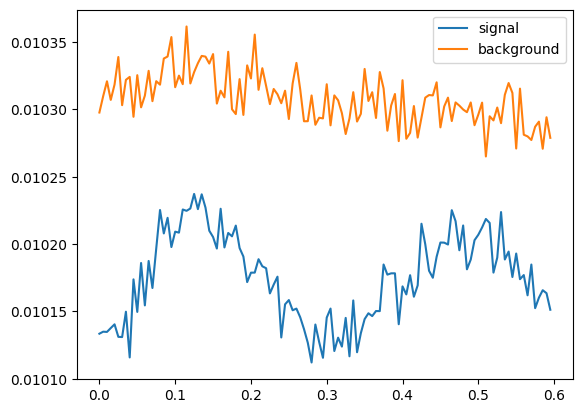

In [13]:
plt.plot(phase_actual, sig_mwon, label="signal")
plt.plot(phase_actual, sig_mwoff, label="background")
# plt.plot(phase_actual, sig_mwon - sig_mwoff, label="signal - background")
plt.legend()
plt.show()

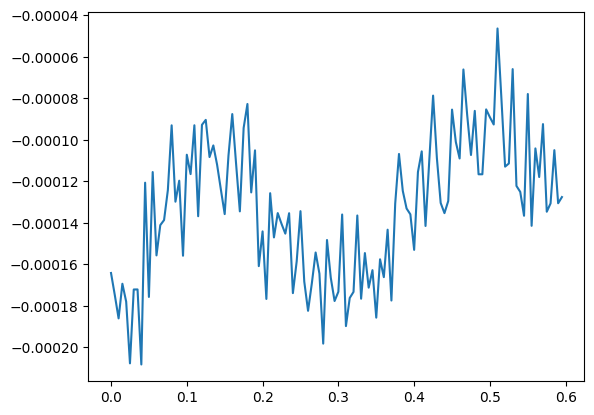

In [14]:
plt.plot(phase_actual, sig_mwon - sig_mwoff, label="signal - background")


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Your original data
x = phase_actual
y = sig_mwon - sig_mwoff

# Define a sine model: A * sin(2π f x + φ) + C
def sine_model(x, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * x + phi) + C

# Initial guess: [Amplitude, Frequency, Phase, Offset]
guess = [np.max(y) - np.min(y), 1 / (x[-1] - x[0]), 0, np.mean(y)]

# Fit the data
popt, _ = curve_fit(sine_model, x, y, p0=guess)

# Generate smooth x values for plotting the fitted curve
x_fit = np.linspace(np.min(x), np.max(x), 1000)
y_fit = sine_model(x_fit, *popt)

# Plot
plt.plot(x, y, label="signal - background")
plt.plot(x_fit, y_fit, label="sine fit", linestyle="--", color="red")
plt.legend()
plt.xlabel("Phase")
plt.ylabel("Signal")
plt.title("Signal - Background with Sine Fit")
plt.show()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [ ]:
# SHUTDOWN THE EXPERIMENT
# # reconnect the mw syn connection
# hw.mwsyn.close_gracefully()
# hw.mwsyn.open()
hw.vdi.set_amp_volt(0)

# turn off laser and set diode current to zero
hw.laser.laser_off()  # turn off laser
hw.laser.set_diode_current(0.0, save_memory=False)

hw.dig.stop_card()
# hw.dig.reset()

# pasue the mw pause then reboot
# hw.mwsyn.sweep_pause()

# mwsyn.reboot()

# clear the pulse sequence
hw.pg.forceFinal()
hw.pg.rearm()
hw.pg.constant(OutputState.ZERO())
# hw.pg.reset()

VDI Synthesizer Serial port closed.
Card stopped
